In [14]:
import pandas as pd
import pickle
import os


df = pd.read_csv("data/rating.txt", sep=";")
df

,nr,episode,rating
0,1,Winter Is Coming,8.9
1,2,The Kingsroad,8.6
2,3,Lord Snow,8.5
3,4,"Cripples, Bastards, and Broken Things",8.6
4,5,The Wolf and the Lion,9.0
...,...,...,...
68,69,A Knight of the Seven Kingdoms,7.9
69,70,The Long Night,7.5
70,71,The Last of the Starks,5.5
71,72,The Bells,5.9


In [15]:
with open('graphs/dg_creators.pickle', 'rb') as f:
    DG_creators = pickle.load(f)

In [16]:
[n for n in DG_creators.nodes() if DG_creators.nodes[n].get('type') == 'episode']

['The Old Gods and the New',
 'House of the Dragon_ Season 3, Episode 8',
 'Baelor',
 'Blackwater',
 'House of the Dragon_ Season 3, Episode 5',
 'Battle of the Bastards (episode)',
 'Hardhome (episode)',
 'Driftmark (episode)',
 'The Dragon and the Wolf',
 'The Climb',
 'Regent (episode)',
 'Sons of the Harpy (episode)',
 'Two Swords',
 'The Laws of Gods and Men',
 'The Rains of Castamere (episode)',
 'Fire and Blood',
 'The Black Queen',
 'The Night Lands',
 'The Broken Man',
 'Lord Snow',
 'The Wolf and the Lion',
 'A Knight of the Seven Kingdoms_ Season 1, Episode 5',
 'A Knight of the Seven Kingdoms_ Season 1, Episode 4',
 'The Heirs of the Dragon',
 'Dragonstone (episode)',
 'The Gift',
 'Beyond the Wall (episode)',
 "Mother's Mercy",
 'A Golden Crown',
 'Valar Morghulis',
 'Smallfolk (episode)',
 'The Lion and the Rose',
 'The Burning Mill',
 'And Now His Watch Is Ended',
 'The Queen Who Ever Was',
 'The Mountain and the Viper',
 'The Red Sowing',
 'A Knight of the Seven Kingdom

In [17]:
import os
import re
import pickle
import pandas as pd

# --- load your graph (you already have this) ---
with open("graphs/dg_creators.pickle", "rb") as f:
    DG_creators = pickle.load(f)

def get_episode_nodes(G):
    """Return node names for all episode nodes."""
    return [n for n, d in G.nodes(data=True) if d.get("type") == "episode"]


def _normalize_title(s):
    """
    Normalize a title/filename for matching:
    - remove the literal substring '(episode)' (any case)
    - lowercase
    - remove all non-alphanumeric chars
    """
    s = str(s)

    # Remove exactly "(episode)" (case-insensitive)
    s = re.sub(r"\(episode\)", "", s, flags=re.IGNORECASE)

    # Strip leftover spaces
    s = s.strip()

    # Lowercase and remove non-alphanumeric characters
    s = re.sub(r"[^a-z0-9]+", "", s.lower())

    return s



def map_episodes_to_files(G, folder="GoT_files"):
    """
    Map episode node names to files.
    Priority:
    1. Exact filename match (case-insensitive), including '(episode)'
    2. Filename match after removing '(episode)' from the episode name
    3. Normalized matching (_normalize_title)
    """
    episode_nodes = [n for n, d in G.nodes(data=True) if d.get("type") == "episode"]

    # List all .txt files
    files = [f for f in os.listdir(folder) if f.lower().endswith(".txt")]

    # Create case-insensitive file lookup
    file_lookup = {f.lower(): f for f in files}

    mapping = {}

    for ep in episode_nodes:
        ep_raw = ep
        ep_lower = ep_raw.lower()

        # ------------------------------
        # 1) EXACT MATCH (including '(episode)')
        # ------------------------------
        if ep_lower + ".txt" in file_lookup:
            mapping[ep_raw] = os.path.join(folder, file_lookup[ep_lower + ".txt"])
            continue

        # ------------------------------
        # 2) match after removing '(episode)'
        # ------------------------------
        ep_clean = re.sub(r"\(episode\)", "", ep_raw, flags=re.IGNORECASE).strip()
        ep_clean_lower = ep_clean.lower()

        if ep_clean_lower + ".txt" in file_lookup:
            mapping[ep_raw] = os.path.join(folder, file_lookup[ep_clean_lower + ".txt"])
            continue

        # ------------------------------
        # 3) NORMALIZED MATCH (old method)
        # ------------------------------

        # normalize both cleaned title and filenames
        target_norm = _normalize_title(ep_clean)

        for file in files:
            file_norm = _normalize_title(os.path.splitext(file)[0])
            if file_norm == target_norm:
                mapping[ep_raw] = os.path.join(folder, file)
                break

    return mapping



In [18]:
def extract_synopsis(text):
    # Flexible, case-insensitive heading:
    # ^==\s*Synopsis\s*==$
    synopsis_heading = r"^==\s*synopsis\s*==\s*$"

    # Pattern: match the heading, then capture everything lazily,
    # until the next '== something ==' heading
    pattern = re.compile(
        synopsis_heading + r"(?P<content>.*?)(?=^==\s*[^=]+?\s*==\s*$)",
        flags=re.I | re.S | re.M,
    )

    m = pattern.search(text)
    if m:
        return m.group("content").strip()

    # Fallback: if Synopsis is the last section
    pattern_fallback = re.compile(
        synopsis_heading + r"(.*)", flags=re.I | re.S | re.M
    )
    m2 = pattern_fallback.search(text)
    return m2.group(1).strip() if m2 else ""


In [19]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

STOPWORDS = set(ENGLISH_STOP_WORDS)

def tokenize(text):
    """
    Tokenize text into lowercase alphabetic words and remove stopwords.
    """
    tokens = re.findall(r"\b[a-zA-Z]+\b", text.lower())
    tokens = [t for t in tokens if t not in STOPWORDS]
    return tokens



In [20]:
def load_labmit_s1(path="data/S1.txt"):
    """
    Load S1 wordlist as {word: happiness_average}.
    Assumes a tab-separated file with columns:
    word, happiness_rank, happiness_average, ...
    """
    df = pd.read_csv(path, sep="\t")  # header is in the file

    # Normalize words to lowercase
    df["word"] = df["word"].astype(str).str.lower()

    # Build dict: word -> happiness_average
    lexicon = dict(zip(df["word"], df["happiness_average"].astype(float)))
    return lexicon


In [21]:
def compute_sentiment(tokens, lexicon):
    """
    Compute sentiment score for a list of tokens using a word→score lexicon.
    Here: arithmetic mean of scores for tokens that are in the lexicon.
    Returns: float or None if no tokens are in the lexicon.
    """
    scores = [lexicon[t] for t in tokens if t in lexicon]
    if not scores:
        return None
    return sum(scores) / len(scores)


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def build_episode_sentiment_df_tfidf(
    G,
    got_folder="GoT_files",
    s1_path="data/Data_Set_S1.txt"
):
    lexicon = load_labmit_s1(s1_path)
    ep_to_file = map_episodes_to_files(G, folder=got_folder)

    episodes = []
    file_paths = []
    synopses = []

    # 1) Collect all synopses first (corpus)
    for ep_name, file_path in ep_to_file.items():
        with open(file_path, encoding="utf-8") as f:
            raw_text = f.read()

        synopsis_text = extract_synopsis(raw_text)
        episodes.append(ep_name)
        file_paths.append(file_path)
        synopses.append(synopsis_text)

    # 2) TF-IDF over the corpus (+ built-in stopword removal)
    vectorizer = TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        token_pattern=r"\b[a-zA-Z]+\b"
    )
    tfidf_matrix = vectorizer.fit_transform(synopses)
    vocab = vectorizer.get_feature_names_out()

    rows = []
    for i, ep_name in enumerate(episodes):
        row = tfidf_matrix[i]
        # nonzero entries
        indices = row.nonzero()[1]

        weighted_scores = []
        weights = []
        lexicon_hits = 0

        for idx in indices:
            term = vocab[idx]
            if term in lexicon:
                w = row[0, idx]
                weighted_scores.append(lexicon[term] * w)
                weights.append(w)
                lexicon_hits += 1

        if weights:
            sentiment_score = sum(weighted_scores) / sum(weights)
        else:
            sentiment_score = None

        # token count (after stopwords) just for info
        tokens = tokenize(synopses[i])
        token_count = len(tokens)

        clean_ep_name = re.sub(r"\(episode\)", "", ep_name, flags=re.IGNORECASE).strip()

        rows.append(
            {
                "episode_raw": ep_name,
                "episode": clean_ep_name,
                "file_path": file_paths[i],
                "token_count": token_count,
                "lexicon_hits": lexicon_hits,
                "sentiment_score": sentiment_score,
            }
        )

    return pd.DataFrame(rows)


In [23]:
df_sentiment = build_episode_sentiment_df_tfidf(
    DG_creators,
    got_folder="GoT_files",
    s1_path="data/Data_Set_S1.txt"
)
df_sentiment

,episode_raw,episode,file_path,token_count,lexicon_hits,sentiment_score
0,The Old Gods and the New,The Old Gods and the New,GoT_files/The Old Gods and the New.txt,780,268,5.255292
1,"House of the Dragon_ Season 3, Episode 8","House of the Dragon_ Season 3, Episode 8","GoT_files/House of the Dragon_ Season 3, Episo...",0,0,NaN
2,Baelor,Baelor,GoT_files/Baelor.txt,1086,407,5.377780
3,Blackwater,Blackwater,GoT_files/Blackwater.txt,632,258,5.151795
4,"House of the Dragon_ Season 3, Episode 5","House of the Dragon_ Season 3, Episode 5","GoT_files/House of the Dragon_ Season 3, Episo...",0,0,NaN
...,...,...,...,...,...,...
103,Garden of Bones (episode),Garden of Bones,GoT_files/Garden of Bones (episode).txt,1496,520,5.366073
104,The Green Council,The Green Council,GoT_files/The Green Council.txt,1276,426,5.466752
105,King of the Narrow Sea (episode),King of the Narrow Sea,GoT_files/King of the Narrow Sea (episode).txt,2767,809,5.581695
106,Home,Home,GoT_files/Home.txt,1143,408,5.358982


In [24]:
def load_ratings(path="data/rating.txt"):
    df = pd.read_csv(path, sep=";", engine="python")

    # Standardize column names
    df.columns = df.columns.str.strip()

    # Episode number should be int
    df["nr"] = df["nr"].astype(int)

    return df


In [25]:
def merge_sentiment_and_ratings(df_sentiment, rating_path="data/rating.txt"):
    df_rating = load_ratings(rating_path)

    # Left merge keeps all episodes from the sentiment DF
    df_merged = df_sentiment.merge(df_rating, on="episode", how="left")

    return df_merged


In [26]:
df_sentiment = build_episode_sentiment_df_tfidf(
    DG_creators,
    got_folder="GoT_files",
    s1_path="data/Data_Set_S1.txt"
)

df_final = merge_sentiment_and_ratings(df_sentiment, "data/rating.txt")
df_final


,episode_raw,episode,file_path,token_count,lexicon_hits,sentiment_score,nr,rating
0,The Old Gods and the New,The Old Gods and the New,GoT_files/The Old Gods and the New.txt,780,268,5.255292,16.0,8.9
1,"House of the Dragon_ Season 3, Episode 8","House of the Dragon_ Season 3, Episode 8","GoT_files/House of the Dragon_ Season 3, Episo...",0,0,NaN,NaN,NaN
2,Baelor,Baelor,GoT_files/Baelor.txt,1086,407,5.377780,9.0,9.6
3,Blackwater,Blackwater,GoT_files/Blackwater.txt,632,258,5.151795,19.0,9.7
4,"House of the Dragon_ Season 3, Episode 5","House of the Dragon_ Season 3, Episode 5","GoT_files/House of the Dragon_ Season 3, Episo...",0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
103,Garden of Bones (episode),Garden of Bones,GoT_files/Garden of Bones (episode).txt,1496,520,5.366073,14.0,8.6
104,The Green Council,The Green Council,GoT_files/The Green Council.txt,1276,426,5.466752,NaN,NaN
105,King of the Narrow Sea (episode),King of the Narrow Sea,GoT_files/King of the Narrow Sea (episode).txt,2767,809,5.581695,NaN,NaN
106,Home,Home,GoT_files/Home.txt,1143,408,5.358982,52.0,9.2


In [27]:
df_final[df_final['rating'] > 0]

,episode_raw,episode,file_path,token_count,lexicon_hits,sentiment_score,nr,rating
0,The Old Gods and the New,The Old Gods and the New,GoT_files/The Old Gods and the New.txt,780,268,5.255292,16.0,8.9
2,Baelor,Baelor,GoT_files/Baelor.txt,1086,407,5.377780,9.0,9.6
3,Blackwater,Blackwater,GoT_files/Blackwater.txt,632,258,5.151795,19.0,9.7
5,Battle of the Bastards (episode),Battle of the Bastards,GoT_files/Battle of the Bastards (episode).txt,1078,379,5.090838,59.0,9.9
6,Hardhome (episode),Hardhome,GoT_files/Hardhome (episode).txt,1271,504,5.369305,48.0,9.8
...,...,...,...,...,...,...,...,...
100,Book of the Stranger,Book of the Stranger,GoT_files/Book of the Stranger.txt,1506,514,5.415562,54.0,9.0
101,Blood of My Blood,Blood of My Blood,GoT_files/Blood of My Blood.txt,1108,415,5.492822,56.0,8.3
102,The Prince of Winterfell,The Prince of Winterfell,GoT_files/The Prince of Winterfell.txt,416,170,5.425940,18.0,8.6
103,Garden of Bones (episode),Garden of Bones,GoT_files/Garden of Bones (episode).txt,1496,520,5.366073,14.0,8.6


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_sentiment_vs_rating(
    df,
    sentiment_col="sentiment_score",
    rating_col="rating",
    episode_col=None  # e.g. "episode" or "episode_name"
):
    """
    Compute stats and plot sentiment vs rating.
    df: DataFrame with sentiment and rating columns.
    """

    # --- Clean and subset ---
    data = df[[sentiment_col, rating_col] + ([episode_col] if episode_col else [])].copy()
    data = data.dropna(subset=[sentiment_col, rating_col])

    print("Number of episodes used:", len(data))

    # --- Summary stats ---
    print("\nSummary statistics:")
    print(data[[sentiment_col, rating_col]].describe())

    # Pearson correlation
    corr = data[sentiment_col].corr(data[rating_col])
    print(f"\nPearson correlation between {sentiment_col} and {rating_col}: {corr:.3f}")

    # --- Scatter plot with regression line ---
    x = data[sentiment_col].values
    y = data[rating_col].values

    # Fit linear regression: y = a*x + b
    a, b = np.polyfit(x, y, 1)
    y_pred = a * x + b

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.6, edgecolor="k")
    # regression line
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = a * x_line + b
    plt.plot(x_line, y_line, linewidth=2)

    plt.xlabel("Sentiment score")
    plt.ylabel("Rating")
    plt.title("Sentiment vs Rating")

    # Optional: annotate a few extreme points
    if episode_col:
        # label top 3 highest and lowest ratings
        top_idx = data[rating_col].nlargest(3).index
        low_idx = data[rating_col].nsmallest(3).index
        for idx in list(top_idx) + list(low_idx):
            row = data.loc[idx]
            plt.annotate(
                str(row[episode_col]),
                (row[sentiment_col], row[rating_col]),
                xytext=(5, 5),
                textcoords="offset points",
                fontsize=8
            )

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Histograms of sentiment and rating ---
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(data[sentiment_col], bins=15, alpha=0.8, edgecolor="k")
    plt.xlabel("Sentiment score")
    plt.ylabel("Count")
    plt.title("Distribution of sentiment scores")

    plt.subplot(1, 2, 2)
    plt.hist(data[rating_col], bins=15, alpha=0.8, edgecolor="k")
    plt.xlabel("Rating")
    plt.ylabel("Count")
    plt.title("Distribution of ratings")

    plt.tight_layout()
    plt.show()

    # --- Mean rating by sentiment quantile (optional but nice) ---
    # 4 quantiles (quartiles) by sentiment
    data["sentiment_bin"] = pd.qcut(data[sentiment_col], 4, labels=["Q1 low", "Q2", "Q3", "Q4 high"])

    mean_by_bin = data.groupby("sentiment_bin")[rating_col].mean()
    print("\nMean rating by sentiment quartile:")
    print(mean_by_bin)

    plt.figure(figsize=(6, 4))
    mean_by_bin.plot(kind="bar")
    plt.ylabel("Mean rating")
    plt.xlabel("Sentiment quartile")
    plt.title("Mean rating by sentiment quartile")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return {"corr": corr, "mean_by_bin": mean_by_bin}


Number of episodes used: 70

Summary statistics:
       sentiment_score     rating
count        70.000000  70.000000
mean          5.410491   8.771429
std           0.106515   0.944265
min           5.085060   4.000000
25%           5.364651   8.600000
50%           5.417643   8.800000
75%           5.480636   9.275000
max           5.610357   9.900000

Pearson correlation between sentiment_score and rating: -0.094


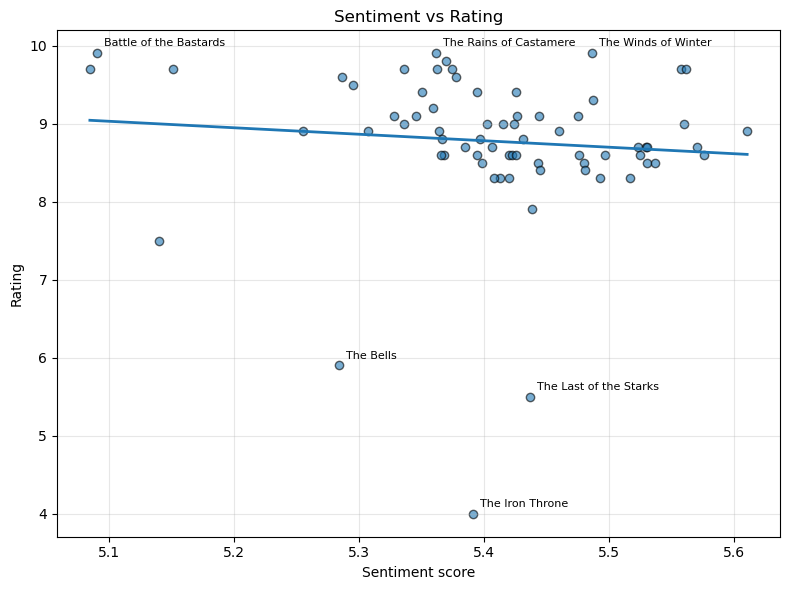

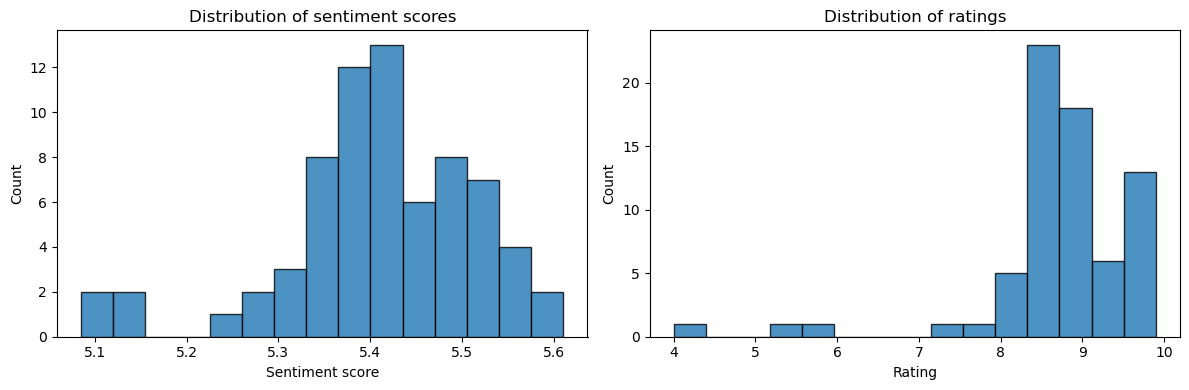


Mean rating by sentiment quartile:
sentiment_bin
Q1 low     9.088889
Q2         8.611765
Q3         8.523529
Q4 high    8.838889
Name: rating, dtype: float64


/var/folders/z6/0dqw2m7n37l5vjqcv_822tdr0000gn/T/ipykernel_79097/2492424731.py:90: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_bin = data.groupby("sentiment_bin")[rating_col].mean()


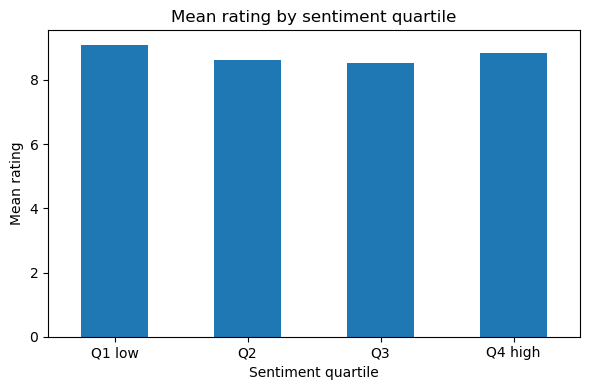

In [29]:
results = analyze_sentiment_vs_rating(
    df_final,
    sentiment_col="sentiment_score",
    rating_col="rating",
    episode_col="episode"  # or "episode_name" if that's your column
)


In [30]:
from scipy.stats import pearsonr
df_corr = df_final.dropna(subset=["sentiment_score", "rating"])
len(df_corr)

r, p = pearsonr(df_corr["sentiment_score"], df_corr["rating"])
print("Correlation:", r)
print("p-value:", p)

Correlation: -0.093850416798477
p-value: 0.43965344002162365
